##### Summarizing Simulation Ensembles

## Exoplanet Yield Modeling Tools Workshop – June 2023

(version of 2023-04-25)

This notebook shows how an ensemble of mission simulations can be loaded into Python, in a tabular format, and summarized to give information about overall yield, scheduling performance, and their variability.

Offline, we ran 100 separate mission simulations (in essence, by scripting `SurveySimulation.run_sim()`). Each has the same OpticalSystem (a 6m telescope with vector vortex coronagraph) and the same `Observatory` and starts from the same `TargetList`. The Monte Carlo averaging is over independent, randomly-drawn planet configurations – the orbits, masses, and other quantities within the `SimulatedUniverse`. 

Each `SurveySimulation` will in principle produce a different observing sequence, as the `SurveySimulation` reacts to detected planets. This yields an ensemble of 100 separate sequences of observations – lists of detections and characterizations. After `run_sim()` finishes, the wrapper writes the observing sequence and target list to `Python` pickle files.

Still offline, we summarized these simulation-by-simulation observing sequences (100 `.pkl` files) into two overall tables: one describing all detections (with their own relevant attributes like integration time and SNR), and the other describing all characterizations (with similar attributes). These, together with a third table of the `TargetList` stellar parameters, are dumped to the CSV files that we analyze here.

This notebook is designed for execution on Google colab. For an offline/binder version, use the version in the Notebooks folder.

First some colab-specific setup:

In [ ]:
# this can take up to a minute or longer
!git clone --depth 1 https://github.com/dsavransky/YieldModelingWorkshopTutorial

In [ ]:
!pip install seaborn

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Ensemble Tabulations

Load the detection, characterization, and target-star CSV files into Pandas tables, taking a quick look at the available attributes.

In [2]:
# 1: load the detections
#    (the CSV is produced by an external script, drm_tabulate.py)
obs_det = pd.read_csv('../Tabulations/H6C/ensemble-dets.csv')
print(f'Ensemble contains {len(obs_det)} detection observations across {len(pd.unique(obs_det.seed))} members')

# establish a convenience variable for later: 
# Nens, the number of ensemble members
Nens = len(pd.unique(obs_det.seed))

# show the first few rows
obs_det.head()

Ensemble contains 14615 detection observations across 100 members


,seed,obs_num,plan_num,arrival_time,det_SNR,det_comp,det_time,det_status,WA,dMag,fEZ,Spec,Name,dist,luminosity,comp0,Mp
0,10185257,5,1,1.968508,2.684593,0.532663,0.009778,0,0.180996,25.279467,3.051053e-10,G9.0V,HIP 96100,5.75,0.44,0.843450,0.561202
1,10185257,9,1,3.996521,7.875436,0.550309,0.028771,1,0.255638,25.177009,3.559339e-09,G3V,HIP 3821 A,5.94,1.31,0.622340,1.293139
2,10185257,27,1,14.933906,5.469566,0.566792,0.142507,0,0.114609,25.219916,1.295377e-09,G6V,HIP 29271,10.20,0.91,0.748776,0.761175
3,10185257,28,1,15.702919,6.252488,0.529378,0.140377,0,0.089765,25.175992,6.346593e-10,G2V,HIP 15371,12.03,1.03,0.719949,0.434291
4,10185257,30,1,16.971472,4.629985,0.670916,0.149361,0,0.177374,25.050170,1.174877e-08,G7.0V,HIP 72659 A,6.78,0.65,0.803219,0.733786


Individual rows are tagged by the random number seed (simulation number), and within that, by observation number. Because detection status is a function of planet, a single detection observation (e.g., number 21 above) may contain a row for two or more planets.

We load the characterizations next.

In [3]:
# 2: load the characterizations - CSV is produced by drm_tabulate.py
obs_char = pd.read_csv('../Tabulations/H6C/ensemble-chars.csv')
print(f'Ensemble contains {len(obs_char)} char observations across {len(pd.unique(obs_char.seed))} members')
# show the first few rows
obs_char.head()

Ensemble contains 2289 char observations across 100 members


,seed,obs_num,plan_num,arrival_time,char_time,Spec,Name,dist,luminosity,comp0,Mp
0,10185257,126,1,101.620682,5.848123,F0Ib-II,HIP 58910,5.52,0.03,0.374962,0.973506
1,10185257,293,1,323.275121,12.236495,G8/K0V,HIP 101997,14.38,0.56,0.745882,2.270693
2,10185257,354,1,474.841224,22.849398,K5/M0V,HIP 113576,8.22,0.10,0.638319,1.069273
3,10185257,360,1,528.955651,10.177812,K5/M0V,HIP 113576,8.22,0.10,0.638319,1.069273
4,10185257,371,1,570.360321,8.633518,K5/M0V,HIP 113576,8.22,0.10,0.638319,1.069273


Finally, load the star properties, which are the same for each ensemble member. 

The planet properties will differ, so we leave them out of this demonstration.

In [4]:
# 3: star properties - CSV is produced by spc-extract.py
spc = pd.read_csv('../Tabulations/H6C/spc.csv')
# the first few rows show the available properties
spc.head()

,seed,Name,Spec,L,MsTrue,comp0,dist
0,10185257,HIP 400,G9V,0.52,0.928026,0.200781,26.39
1,10185257,HIP 439,M1.5V,0.02,0.507314,0.423973,4.34
2,10185257,HIP 473 A,K2,0.09,0.575119,0.166153,11.31
3,10185257,HIP 522,F7V,3.00,1.286784,0.151266,25.71
4,10185257,HIP 544,K0V,0.68,0.985585,0.751110,13.67


## Examining Yield

Let's find out how many detections were made. We don't want to double-count detection observations on multi-planet systems, so we filter to only include rows for the first planet, successfully-detected or not (`plan_num == 1` below). This could therefore be considered a star-by-star detection count.

In [5]:
# detections-performed histogram
bins_dets = np.arange(0, 200, 5)
# counts stars visited for detections
dets_stars = obs_det.loc[obs_det.plan_num == 1].seed.value_counts()
print(f'The mission-by-mission detection counts are indexed by seed number, and are sorted into descending order:')
dets_stars.head()

The mission-by-mission detection counts are indexed by seed number, and are sorted into descending order:


631110355    189
725665633    184
64295535     178
611229025    178
357337548    177
Name: seed, dtype: int64

On average we made 136.15 ± 21.38 detection observations.


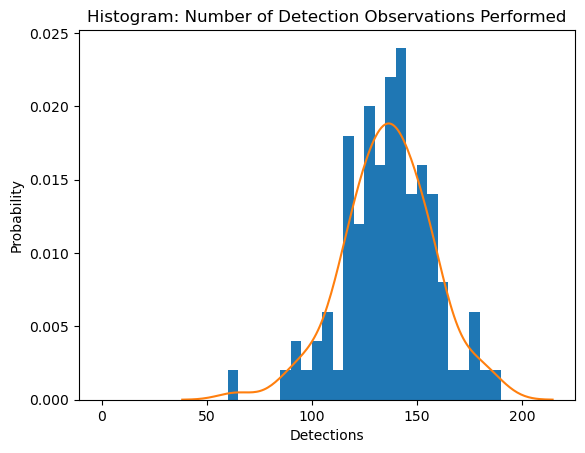

In [6]:
# bar-style plot
plt.hist(dets_stars, bins=bins_dets, density=True)
# overlay a smoothed version of the same histogram
sns.kdeplot(data=list(dets_stars))
plt.title('Histogram: Number of Detection Observations Performed')
plt.xlabel('Detections')
plt.ylabel('Probability')
# the sum of (#detections) divided by the ensemble size is the average detection yield
print(f'On average we made {np.mean(dets_stars):.2f} ± {np.std(dets_stars):.2f} detection observations.')

Let's do the same plot for the characterizations.

On average we made 20.80 ± 6.14 characterization observations.


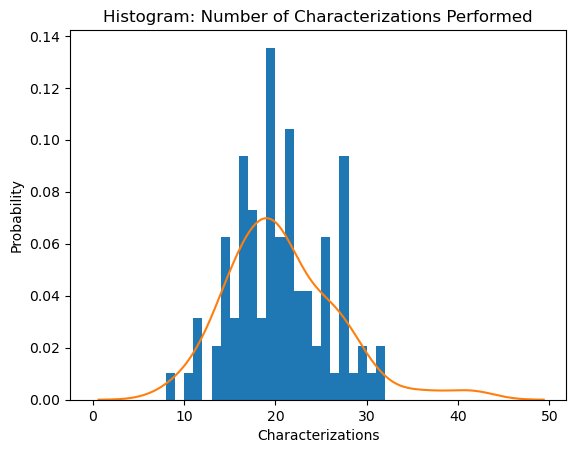

In [7]:
# chars-performed histogram
bins_chars = np.arange(0, 35, 1)
# counts stars visited for characterizations
chars_stars = obs_char.loc[obs_char.plan_num==1].seed.value_counts()
# bar-style plot
plt.hist(chars_stars, bins=bins_chars, density=True)
# overlay a smoothed version of the same histogram
sns.kdeplot(data=list(chars_stars))
plt.title('Histogram: Number of Characterizations Performed')
plt.xlabel('Characterizations')
plt.ylabel('Probability')
print(f'On average we made {np.mean(chars_stars):.2f} ± {np.std(chars_stars):.2f} characterization observations.')

Is there a tradeoff or a synergy between detections and characterizations? 

Let's make the scatterplot to see if there's a relationship. 

Important: we use `.sort_index()` to sort the counts by the random number seed, so that there is element-by-element correspondence between `dets_per_drm` and `chars_per_drm`.

Text(0.5, 1.0, 'Characterizations vs. Detection Observations')

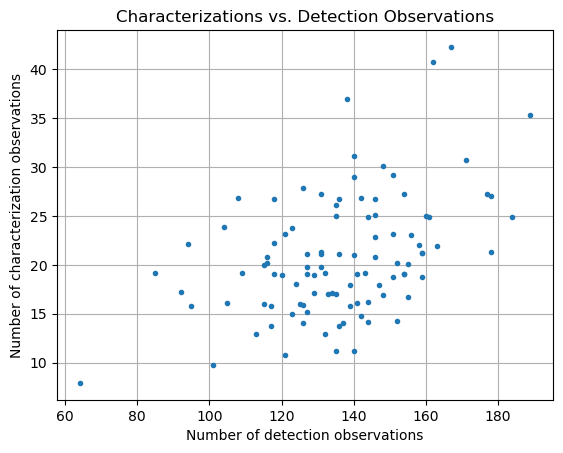

In [8]:
# Scheduling insights: number of chars vs. number of detections

# dither the characterizations to prevent over-plotting of the dots
dither = np.random.uniform(-0.3,0.3, size=len(dets_stars))

plt.plot(dets_stars.sort_index(), chars_stars.sort_index()+dither, '.')
plt.grid()
plt.xlabel('Number of detection observations')
plt.ylabel('Number of characterization observations')
plt.title('Characterizations vs. Detection Observations')

There seems to be a weak positive relationship at least. 

Let's use `seaborn` to dignify the above plot with the marginal distributions (same as originally plotted above) as well as a regression line.

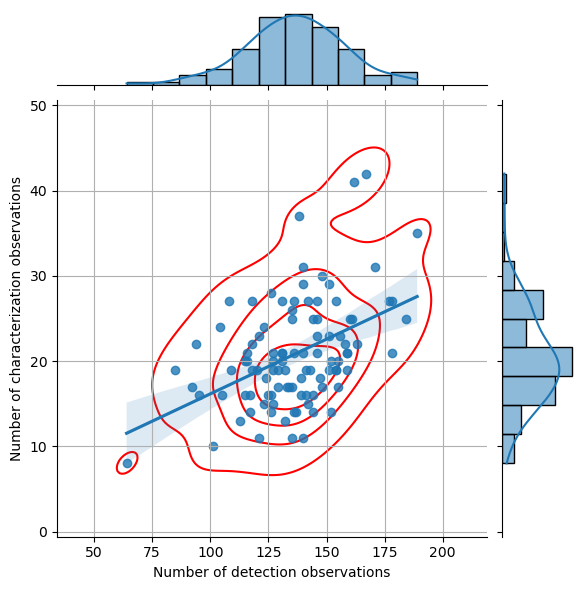

In [9]:
g = sns.jointplot(x=dets_stars.sort_index(), y=chars_stars.sort_index(), kind='reg')
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=5)
plt.xlabel('Number of detection observations')
plt.ylabel('Number of characterization observations')
plt.grid()

## Yield versus Stellar Properties

Yield can be more informative if shown not as a globally-averaged count, but sliced according to various properties. Let's work towards plots of yield with stellar properties as the independent variable.

Here's a quick way to look at yield by distance and luminosity.  These two variables are recorded for each observation in the `obs_char` DataFrame (see above, where we read this table). So, we can just show the set of (distance, luminosity) pairs for each observation. 

As an enhancement, instead of showing a generic marker for the observation, we color the dot by `comp0`, the first-visit completeness of an Earthlike planet for this star, which is also a tabulated property.

All stars observed more than once in the ensemble are over-plotted, but this is a first step.

/var/folders/m2/11pg8ytd2b32gg02912yvzzm0000gn/T/ipykernel_45225/2202709324.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm, label='First-Visit Completeness')


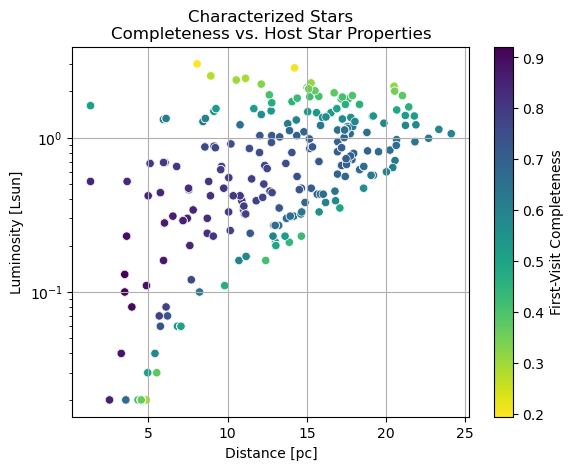

In [10]:
# <property> vs (distance, luminosity)
# note: this scatterplot contains overplots as one star is visited by many seeds
ax = sns.scatterplot(data=obs_char, x='dist', y='luminosity', hue='comp0', palette='viridis_r')
plt.yscale('log')
plt.title('Characterized Stars\nCompleteness vs. Host Star Properties')
plt.xlabel('Distance [pc]')
plt.ylabel('Luminosity [Lsun]')
plt.grid()

# colorbar outside the plot
sm = plt.cm.ScalarMappable(cmap="viridis_r")
sm.set_array(obs_char.comp0)

# Remove the legend and add the colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, label='First-Visit Completeness')

We begin to see a characteristic shape in this plot, with a core of high-completeness stars and a periphery of more distant stars with unfavorable Working Angle. Let's reformat our table to get an as-simulated average yield for these stars, instead of just the average (the completeness).

We need to make a table of yield but indexed by star. We use a `pivot_table` to "transpose" `obs_char` so it is indexed by one of its columns, the star name (`Name`).

Each row of this transposed table corresponds to one star, which will in general be observed many times. The `pivot` must aggregate these observations to produce a single row with scalar column values (`arrival_time`, `dist`(ance), `luminosity`). For one star, all instances of `dist` and `luminosity` will be the same, so we aggregate these (arbitrarily) by taking the `np.mean`. In contrast, we aggregate the `arrival_time` by counting, which produces a count of characterizations on that star. (As above, we filter `obs_char` by `plan_num == 1` to count each characterization observation once, even if two planets are present.)

The following line renames the (already-aggregated) `arrival_time` column to `char_count`, and the final step divides the per-star characterization count by the number of ensemble members to produce an average yield for that star.

In [11]:
# We would like to plot average yield across the ensemble in a similar format

# Tabulate star-by-star yield as a pivot table
#   (counting arrival_time is a trick to get a yield)
yield_starname = obs_char.loc[obs_char.plan_num==1].pivot_table(values=['arrival_time', 'dist', 'luminosity'], index='Name', aggfunc={'arrival_time': 'count', 'dist':np.mean, 'luminosity': np.mean})
yield_starname = yield_starname.rename(columns={'arrival_time': 'char_count'})
# yield = (#chars) / Nens
yield_starname.insert(0, 'yield', value=yield_starname.char_count/Nens)
print(f'We observed {len(yield_starname)} unique stars - pivot table has one row per star')
yield_starname.head()

We observed 215 unique stars - pivot table has one row per star


,yield,char_count,dist,luminosity
Name,,,,
HIP 100017,0.15,15,17.57,1.18
HIP 100925,0.02,2,19.52,0.81
HIP 10138,0.16,16,10.78,0.42
HIP 101997,0.14,14,14.38,0.56
HIP 103096,0.20,20,7.05,0.06


The above table will allow us to make the per-star yield plot. We put two related plots below.

The left subplot just shows the completeness of the `TargetList` versus distance and luminosity. It uses information straight from the `spc` Data Table. The decline in completeness for distant stars is clearer with more stars shown.

The right subplot shows yield, with the `TargetList` plotted in small gray points. The maximum attainable yield is at least a factor of `eta_earth` less than the completeness on the left plot.

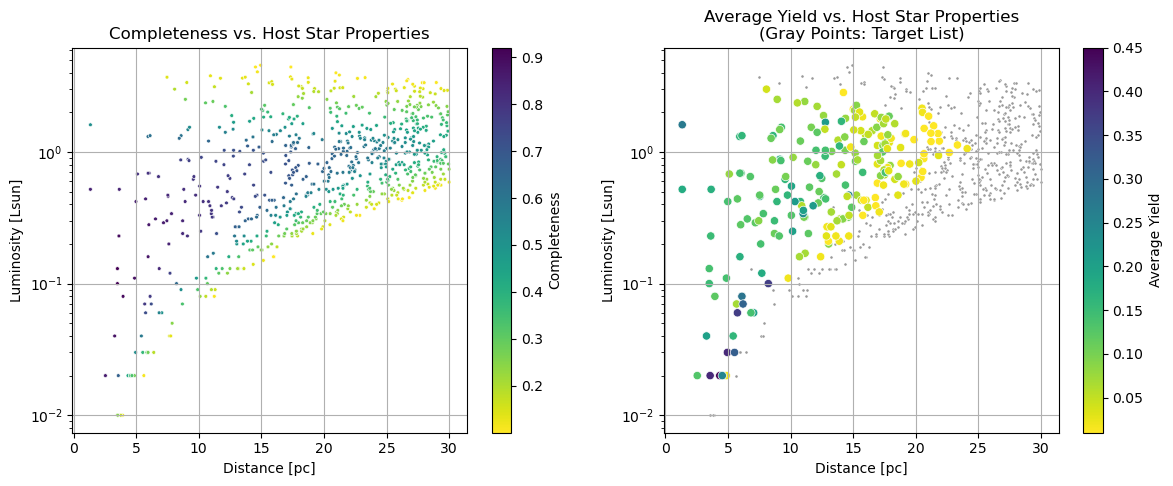

In [12]:
# Now show entire TargetList, and ensemble's yield
fig = plt.figure(figsize=(14,5))
axs = fig.subplots(1,2)

# LHS plot: Target List completeness
sns.scatterplot(data=spc, x='dist', y='L', hue='comp0', marker='.', s=30, palette='viridis_r', ax=axs[0])
axs[0].set_title('Completeness vs. Host Star Properties')

# colorbar outside the plot
sm = plt.cm.ScalarMappable(cmap="viridis_r")
sm.set_array(spc['comp0'].values)
axs[0].get_legend().remove()
fig.colorbar(sm, ax=axs[0], label='Completeness')

# RHS plot: Yield overlaid on Target List
sns.scatterplot(data=spc, x='dist', y='L', marker='.', color="0.6", s=20, legend=None, ax=axs[1])
# yield is from the per-star yield table, as above
sns.scatterplot(data=yield_starname, x='dist', y='luminosity', hue='yield', palette='viridis_r', ax=axs[1])
axs[1].set_title('Average Yield vs. Host Star Properties\n(Gray Points: Target List)')

# colorbar outside the plot
sm = plt.cm.ScalarMappable(cmap="viridis_r")
sm.set_array(yield_starname['yield'].values)
axs[1].get_legend().remove()
fig.colorbar(sm, ax=axs[1], label='Average Yield')

# settings common to both figures
for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('Distance [pc]')
    ax.set_ylabel('Luminosity [Lsun]')
    ax.grid()


## Quantities by Mission Elapsed Time

Let's shift again to consider mission elapsed time, an independent variable that gives insight into scheduling and the target pool.

The simplest plot bins the characterizations, across the ensemble, versus arrival time quantized in months of 30 days. Many such attributes can be plotted by binning each realization of that attribute (e.g., integration time, or spectral class).

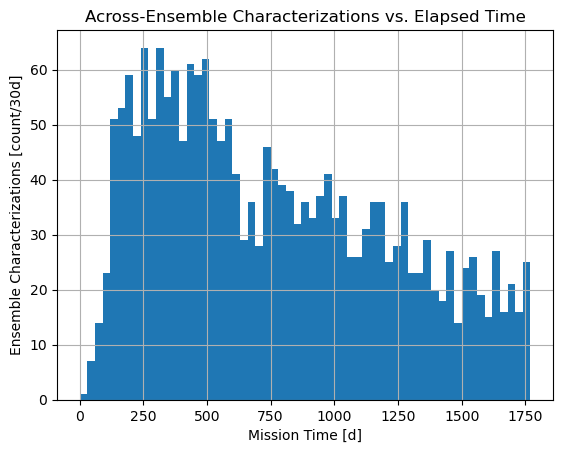

In [13]:
# chars vs. time
bins_missiontime = np.arange(0, 360*5, 30)
plt.hist(obs_char.loc[obs_char.plan_num==1].arrival_time, bins=bins_missiontime)
plt.title('Across-Ensemble Characterizations vs. Elapsed Time')
plt.xlabel('Mission Time [d]')
plt.ylabel('Ensemble Characterizations [count/30d]')
plt.grid()

We can see performance begin to decay after about 500 days as we cover the part of the `TargetList` accessible to our particular photon bucket.

This is a quick way to get a qualitative understanding. It has a flaw: realizations having more characterizations are more highly-weighted than those with few. The characterization yield histogram above show that typical realizations vary by a factor of more than two in the characterization-count, so this biased weighting may be significant. 

To clarify this point: the plot above makes sense if we wanted to choose a random characterization and ask when it happened. But in fact we want to choose a random *realized mission* and ask when its characterizations happened. 

To fix this, we need to average uniformly across ensemble members, rather than uniformly across characterizations. This is nothing more than properly carrying out Monte Carlo averaging. 

The process we follow below is: 
- group the observations by seed (i.e., by `SimulatedUniverse` and as-scheduled mission), 
- compute the per-mission characterization count (binning by independent variable)
- average those binned counts across seed

This is broadly applicable to any Monte Carlo average as a function of any independent variable.

In [14]:
# We must group the ensemble by seed to get across-ensemble means.
ens = obs_char.groupby(by='seed')
print(f'Ensemble has {len(ens)} distinct seeds')

Ensemble has 100 distinct seeds


This `ens` object is in essence a dictionary mapping `seed` to a `DataFrame` containing a table of characterizations. Let's look into the `ens` group.

In [15]:
# ens can be unpacked into a dictionary mapping seed -> dataframe
[f'The DataFrame for seed = {seed} has {len(d)} characterizations' for seed, d in ens][:10]

['The DataFrame for seed = 10185257 has 23 characterizations',
 'The DataFrame for seed = 21494941 has 41 characterizations',
 'The DataFrame for seed = 24252530 has 28 characterizations',
 'The DataFrame for seed = 34757885 has 28 characterizations',
 'The DataFrame for seed = 36709893 has 21 characterizations',
 'The DataFrame for seed = 40110675 has 17 characterizations',
 'The DataFrame for seed = 40442095 has 20 characterizations',
 'The DataFrame for seed = 46942734 has 22 characterizations',
 'The DataFrame for seed = 53210113 has 26 characterizations',
 'The DataFrame for seed = 55534256 has 44 characterizations']

Here is what one of these "single-mission" observation tables looks like.

The `plan_num` attribute is sometimes "2", indicating that two stars were characterized. For this plot, we will count this as two characterizations.

In [16]:
# show observations for the first simulation (DRM)
ens_one = ens.get_group(10185257)
print(f'Group member type is: {type(ens_one)}')
ens_one

Group member type is: <class 'pandas.core.frame.DataFrame'>


,seed,obs_num,plan_num,arrival_time,char_time,Spec,Name,dist,luminosity,comp0,Mp
0,10185257,126,1,101.620682,5.848123,F0Ib-II,HIP 58910,5.52,0.03,0.374962,0.973506
1,10185257,293,1,323.275121,12.236495,G8/K0V,HIP 101997,14.38,0.56,0.745882,2.270693
2,10185257,354,1,474.841224,22.849398,K5/M0V,HIP 113576,8.22,0.10,0.638319,1.069273
3,10185257,360,1,528.955651,10.177812,K5/M0V,HIP 113576,8.22,0.10,0.638319,1.069273
4,10185257,371,1,570.360321,8.633518,K5/M0V,HIP 113576,8.22,0.10,0.638319,1.069273
5,10185257,378,1,599.656503,10.875772,K1V,HIP 81300,9.75,0.47,0.808725,0.697722
6,10185257,379,1,621.892048,9.686877,K5/M0V,HIP 113576,8.22,0.10,0.638319,1.069273
7,10185257,391,1,663.287718,8.594465,K5/M0V,HIP 113576,8.22,0.10,0.638319,1.069273
8,10185257,400,1,704.143263,9.942936,K5/M0V,HIP 113576,8.22,0.10,0.638319,1.069273
9,10185257,409,1,744.517944,15.844807,K5/M0V,HIP 113576,8.22,0.10,0.638319,1.069273


We are all set. We make a function to compile a list of observation times into a single-mission histogram, and then compute one such histogram for each mission, stacking them vertically. 

In [17]:
# function converts a list of times into a histogram with bins across mission time
mission_binner = lambda times: np.histogram(times, bins=bins_missiontime)[0]
# one arrival-time histogram per DRM
arrival_hists = np.stack(list(mission_binner(d.arrival_time) for seed,d in ens))
print(f'Histograms are shaped as Nens x bins: {arrival_hists.shape}')
print(f'Sample single-mission histogram:\n {arrival_hists[0,:]}')

Histograms are shaped as Nens x bins: (100, 59)
Sample single-mission histogram:
 [0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 2 1 0 1 1 1 1 0 1 0 2 1 0 2 0 0 1 0
 0 0 2 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]


The ensemble mean of (characterizations/month) is simply the mean of this stack of histograms, and the standard deviation due to variability in the `SimulatedUniverse`, and to scheduling and its interaction with keepout and zodiacal light, is the standard deviation of the stack.

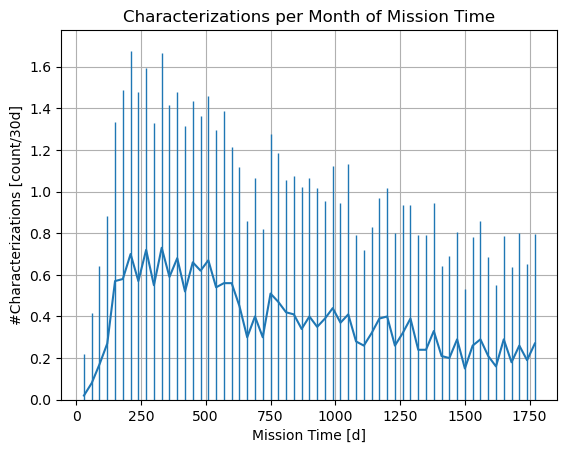

In [18]:
# we can now find the ensemble mean and standard deviation
# to understand the true variability due to simulated universe and scheduling
plt.errorbar(bins_missiontime[1:], np.mean(arrival_hists, axis=0), yerr=np.std(arrival_hists, axis=0), elinewidth=1)
plt.ylim(0.0) # suppress negative-going formal error bars
plt.title('Characterizations per Month of Mission Time')
plt.xlabel('Mission Time [d]')
plt.ylabel('#Characterizations [count/30d]')
plt.grid()

This is a generic and powerful technique. 

We can quantify what is causing saturation by binning characterization integration time according to the same bins.

Here, instead of averaging *counts* of characterizations within slices of our independent variable (mission time), we are averaging the *integration time* needed by those characterizations.

Again, we have a stack of per-bin integration times, as a function of mission time and ensemble member. Bins with no characterization present have `NaN`, and are naturally skipped in the average later.

In [19]:
# find the mean integration time for chars falling within a bin of mission time
int_time_binner = lambda int_times, arr_times: stats.binned_statistic(arr_times, int_times, bins=bins_missiontime)[0]
# find one such
print('Here is a single list of binned integration times for a single DRM:')
print(int_time_binner(ens_one.char_time, ens_one.arrival_time))
# OK, find them all
int_time_hists = np.stack(list(int_time_binner(d.char_time, d.arrival_time) for seed,d in ens))
# result is a stack of mean integration times
print(f'Stack of histograms has shape Nens x bins: {int_time_hists.shape}')


Here is a single list of binned integration times for a single DRM:
[        nan         nan         nan  5.84812317         nan         nan
         nan         nan         nan         nan 12.23649518         nan
         nan         nan         nan 22.84939802         nan 10.17781151
         nan  9.75464503  9.68687743         nan  8.5944647   9.94293592
 15.84480747 15.91726627         nan 24.84841654         nan  5.44960862
 26.86092928         nan  6.58748263         nan         nan 15.31114913
         nan         nan         nan 17.403075           nan         nan
  9.94517478         nan         nan         nan         nan         nan
  6.18083487         nan         nan         nan         nan         nan
         nan  8.72483217         nan         nan         nan]
Stack of histograms has shape Nens x bins: (100, 59)


We use the same technique (take the mean across the ensemble) to find the average characterization integration time. As the mission proceeds, we begin to bump against our integration-time threshold of 60 days.

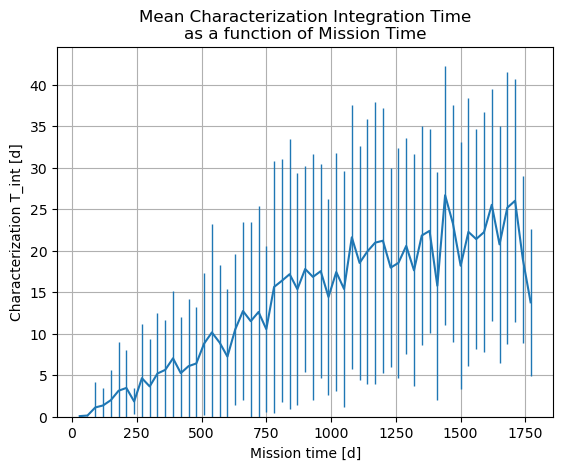

In [20]:
# Plot: ensemble-average integration time as a function of mission time
# note, we use np.nanmean to exclude "no-observation" bins from the ensemble mean
plt.errorbar(bins_missiontime[1:], np.nanmean(int_time_hists, axis=0), np.nanstd(int_time_hists, axis=0), elinewidth=1)
plt.ylim(0.0) # suppress negative-going formal error bars
plt.title('Mean Characterization Integration Time\nas a function of Mission Time')
plt.ylabel('Characterization T_int [d]')
plt.xlabel('Mission time [d]')
plt.grid()

## Summary

We've illustrated these points about analysis of ensembles of simulations:
- You can capture most information relating to yield and scheduling efficiency by reducing runs into tables of observation characteristics, pooled over the ensemble.
- These tables of detection and characterization observations allow you to compute overall yield metrics using just a few lines of code.
- By bucketing the yields by star name, you can compute per-star yields. Adding another table for the `TargetList` allows these yields to be contextualized via physical characteristics like distance, luminosity, or spectral class.
- The *modus operandi* is to bin a quantity of interest (yield, integration time, etc.) versus some independent variable. When doing this, average out over the ensemble to get means, standard deviations, percentiles, or other characterizations of the quantity of interest.

And also, two important details:
- Care about counting is needed. Our choices regarding how to count revisits, planet types, or detections of one versus many planets, depend on our analysis objectives.
- To get correct Monte Carlo averages, average out by uniformly weighting each ensemble member.